In [1]:
# change to True if you use Google Colaboratory:
GoogleColaboratory = False

In [2]:
import os, sys, importlib

if GoogleColaboratory :

    !pip3 install healpy
    
    user = "mahlers77"
    repo = "KSETA2023"

    if os.path.isdir(repo):
        !rm -rf {repo}

    !git clone https://github.com/{user}/{repo}.git

    if not repo in sys.path:
        sys.path.insert(1, repo)

else :
    repo = "."

#for path in sys.path : 
#  print(path)

In [3]:
%matplotlib inline
import numpy as np
from pylab import *
import matplotlib.pyplot as plt

import healpy as H

from scipy.special import erfc # complement of error function: 1-erf
from scipy.special import binom
from scipy.special import gammainc # regularized lower incomplete gamma function

In [4]:
#dirname = 'KSETA2023/data/icecube_10year_ps/events/'
dirname = '/data/icecube_10year_ps/events/'
filenames = ['IC86_I_exp.csv','IC86_II_exp.csv','IC86_III_exp.csv','IC86_IV_exp.csv',\
             'IC86_V_exp.csv','IC86_VI_exp.csv','IC86_VII_exp.csv']

RA = []
DEC = []
energy = []
lines = np.array([])

for filename in filenames:
    
    temp = np.array([line.strip() for line in open(repo + dirname + filename)])
    lines = np.concatenate((lines,temp[1:]))
    
rows = np.array([row.split() for row in lines])

In [5]:
energy = np.array([float(element) for element in rows[:,1]])
RA = np.array([float(element) for element in rows[:,3]])
DEC = np.array([float(element) for element in rows[:,4]])

energy_cut = 0.0 # units of log_10 (E/GeV)
RA = RA[energy >= energy_cut]
DEC = DEC[energy >= energy_cut]

/Users/mahlers/.pyenv/versions/3.7.7/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/Users/mahlers/.pyenv/versions/3.7.7/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/Users/mahlers/.pyenv/versions/3.7.7/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In futur

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


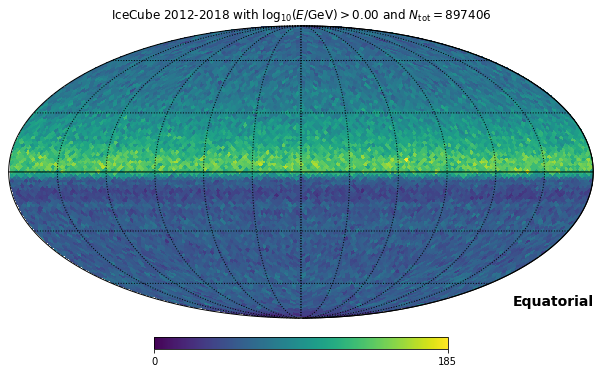

In [6]:
nside = 32
npix = H.nside2npix(nside)
eventmap = np.zeros(npix)

pixels = H.ang2pix(nside,np.pi/2-DEC/180.*np.pi,RA/180.*np.pi)

for i in range(0,len(pixels)) :
    eventmap[pixels[i]] += 1
  
tit = r'IceCube 2012-2018 with $\log_{10}(E/{\rm GeV})>' + format(energy_cut, '.2f') + r'$ and $N_{\rm tot} =' + format(len(RA), '.0f') +  '$'

H.mollview(eventmap,title=tit,coord='C',cbar=True,rot=180,min=0)
H.graticule()


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


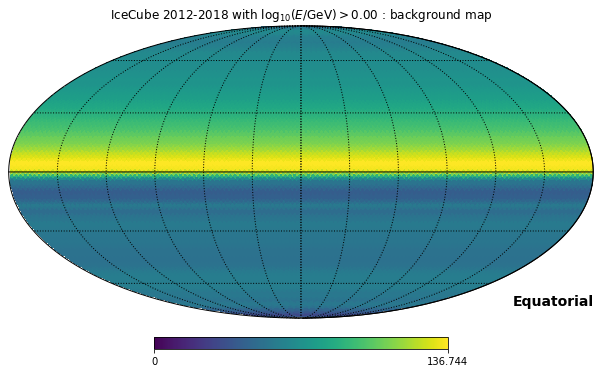

In [7]:
nsideHIGH = 512
high_res_map = H.ud_grade(eventmap,nsideHIGH)
LMAX = 4*nsideHIGH

out  = H.anafast(high_res_map,alm=True,lmax=LMAX)
outBGR = np.zeros_like(out[1])

for i in range(0,LMAX+1) :
    
    index = H.sphtfunc.Alm.getidx(LMAX,i,0)
    outBGR[index] = out[1][index]

high_res_map = H.alm2map(outBGR,nsideHIGH,lmax=LMAX,verbose=False)

backgroundmap = H.ud_grade(high_res_map,nside)

signalmap = eventmap-backgroundmap

tit = r'IceCube 2012-2018 with $\log_{10}(E/{\rm GeV})>' + format(energy_cut, '.2f') + r'$ : background map'

H.mollview(backgroundmap,title=tit,coord='C',cbar=True,rot=180,min=0)
H.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


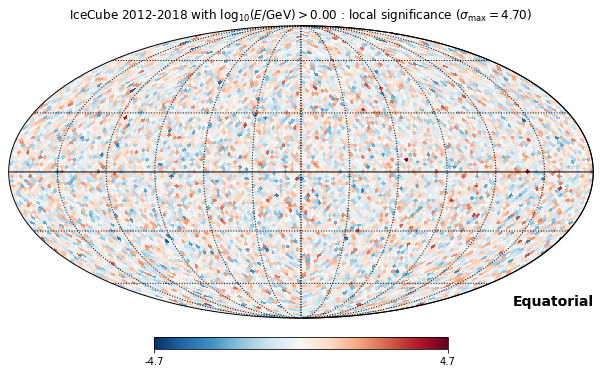

In [8]:
totevents = np.sum(eventmap)
TSmap = np.zeros(npix)

for i in range(0,npix) :
    
    bestfit = (eventmap[i]*npix-totevents)/(npix-1)
    
    temp = 0.0
    if eventmap[i] > 0.0 :
          temp = -2*(eventmap[i]*np.log(backgroundmap[i]/eventmap[i])+eventmap[i]-backgroundmap[i])
    TSmap[i] = temp   
    
    
mymax=max(np.amax(sqrt(TSmap)),-np.amin(sqrt(TSmap)))
digits = int(np.ceil(-np.log(mymax)/np.log(10)))+1
mymax = np.around(mymax, decimals=digits)

tit = r'IceCube 2012-2018 with $\log_{10}(E/{\rm GeV})>' + format(energy_cut, '.2f') + r'$ : local significance ($\sigma_{\rm max} = ' + format(mymax, '.2f') + '$)'

H.mollview(np.sign(signalmap)*sqrt(TSmap),title=tit,coord='C',cbar=True,rot=180,cmap="RdBu_r",min=-mymax,max=mymax)
H.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


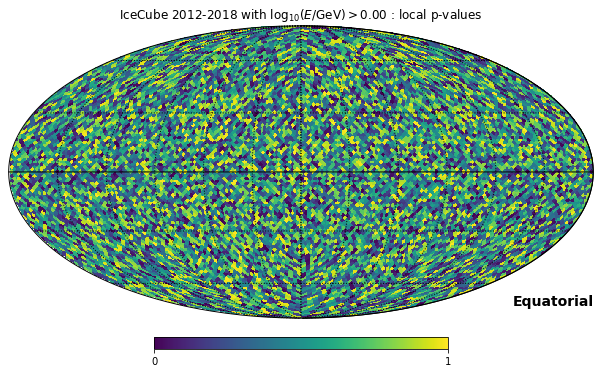

In [9]:
tit = r'IceCube 2012-2018 with $\log_{10}(E/{\rm GeV})>' + format(energy_cut, '.2f') + r'$ : local p-values'

H.mollview(erfc(sqrt(TSmap/2)),title=tit,coord='C',cbar=True,rot=180,min=0,max=1)
H.graticule()


In [10]:
# ranked list of observed p-values:
pvalues = sort(erfc(sqrt(TSmap/2)))

# binomial probability
Pk_obs = [gammainc(kmax,npix*pvalues[kmax-1]) for kmax in range(1,100)]

log_binomial_test_obs = -np.log(min(Pk_obs))/np.log(10)

# generate RUNS random samples
Pk_random = []

log_binomial_test = []

RUNS = 10000

for i in range(0,RUNS) :
    pvalues_random = sort(np.random.rand(npix))
    Pk_temp = [gammainc(kmax,npix*pvalues_random[kmax-1]) for kmax in range(1,100)]
    Pk_random.append(Pk_temp)

    log_binomial_test.append(-np.log(min(Pk_temp))/np.log(10))
    
log_binomial_test = np.array(log_binomial_test)
Pk_random = np.array(Pk_random)

Pk50 = [mean(Pk_random.transpose()[i-1]) for i in range(1,100)]
Pk84 = [np.quantile(Pk_random.transpose()[i-1],0.84) for i in range(1,100)]
Pk16 = [np.quantile(Pk_random.transpose()[i-1],0.16) for i in range(1,100)]

pvalue_BT = len(log_binomial_test[log_binomial_test > log_binomial_test_obs])/len(log_binomial_test)
print('p-value of binomial test : ',pvalue_BT)

p-value of binomial test :  0.129


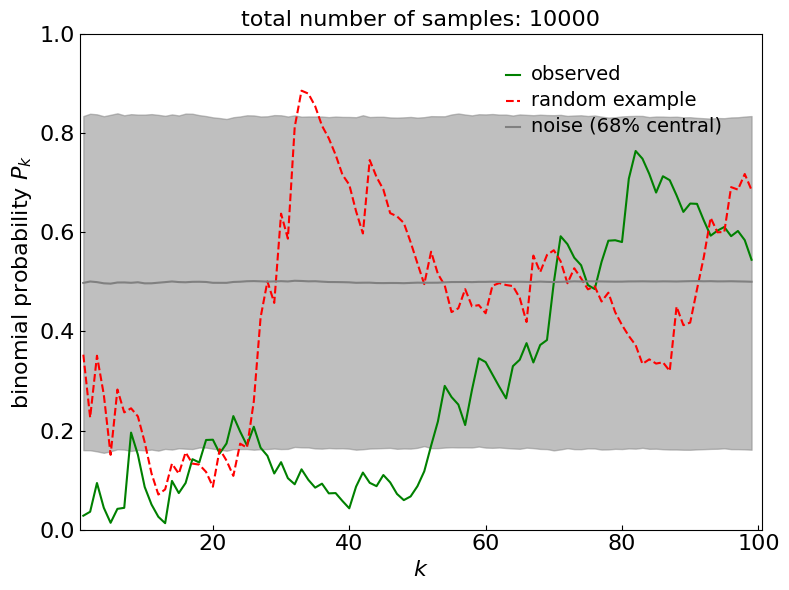

In [11]:
# plot histograms of simulation

fig = figure(dpi=100,tight_layout=True,figsize=(8, 6))
ax = fig.add_subplot(1,1,1)
xlim([0.5,100.5])
ylim([0,1])

title(r'total number of samples: ' + str(RUNS),fontsize=16)
xlabel(r'$k$',fontsize=16)
ylabel(r'binomial probability $P_k$',fontsize=16)
ax.tick_params(axis='both',which='both',direction='in')

for tick in ax.xaxis.get_major_ticks() :
    tick.label.set_fontsize(16) 

for tick in ax.yaxis.get_major_ticks() :
    tick.label.set_fontsize(16)  

x = np.arange(1,100,1)

plot(x,Pk_obs,color='green',label=r'observed')
plot(x,Pk_random[0],color='red',linestyle="--",label=r'random example')
plot(x,Pk50,color='gray',label=r'noise (68% central)')
ax.fill_between(x,Pk16,Pk84,color='gray',alpha=0.5)

leg = plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.,fancybox=False,\
                 framealpha=0.0,frameon=True,numpoints=1, scatterpoints = 1,handlelength=1)
for t in leg.get_texts() :
    t.set_fontsize(14)

plt.show()

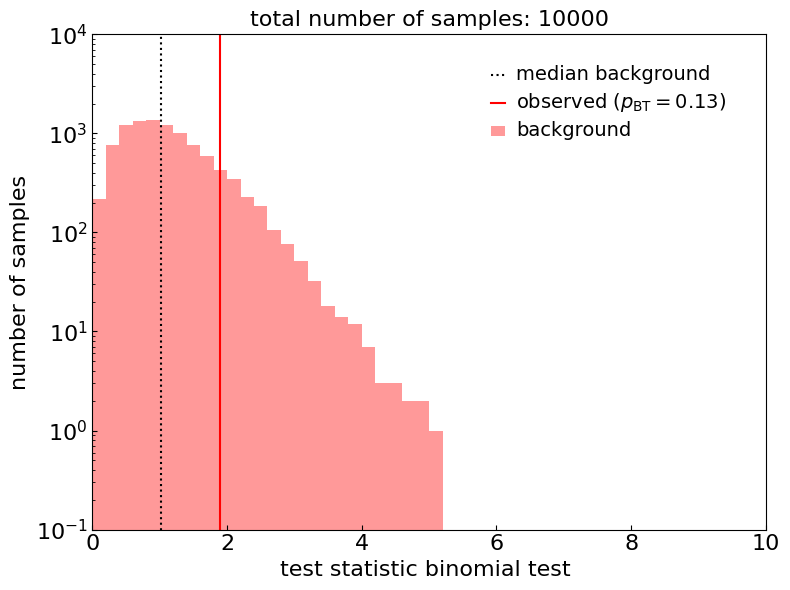

In [12]:
NKS = 50
delta = 0.2

# plot histograms of simulation

fig = figure(dpi=100,tight_layout=True,figsize=(8, 6))
ax = fig.add_subplot(1,1,1)

xlim([0,10])
ylim([0.1,RUNS])

title(r'total number of samples: ' + str(RUNS),fontsize=16)
xlabel(r'test statistic binomial test ',fontsize=16)
ylabel(r'number of samples',fontsize=16)
ax.tick_params(axis='both',which='both',direction='in')

for tick in ax.xaxis.get_major_ticks() :
    tick.label.set_fontsize(16) 

for tick in ax.yaxis.get_major_ticks() :
    tick.label.set_fontsize(16)  
    
bins=np.arange(0,NKS*delta,delta)   
plt.hist(log_binomial_test,bins=bins,log=True,alpha=0.4,color="red",label=r'background')

med = np.median(log_binomial_test)
plt.plot(np.array([med,med]),np.array([0.01,RUNS]),color="black",linestyle="dotted",label=r'median background')
plt.plot(np.array([log_binomial_test_obs,log_binomial_test_obs]),np.array([0.01,RUNS]),color="red",linestyle="solid",\
         label=r'observed ($p_{\rm BT}=' + format(pvalue_BT, '.2f') + '$)')

leg = plt.legend(bbox_to_anchor=(0.95, 0.95), loc=1, borderaxespad=0.,fancybox=False,\
                 framealpha=0.0,frameon=True,numpoints=1, scatterpoints = 1,handlelength=1)
for t in leg.get_texts() :
    t.set_fontsize(14)

plt.show()